In [1]:
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
os.chdir(r"C:\Users\iimam\Documents\Week 12")
artist_info = pd.read_csv("featured_Spotify_artist_info.csv")
spotify_data = pd.read_csv("featured_Spotify_track_info.csv")

In [ ]:
# Clustering - Feature selection 
spotify_data.columns

# acousticness
# danceability
# energy
# instrumentalness
# valence
# tempo

In [3]:
spotify_data.dropna(inplace = True)

In [4]:
# Preprocessing - drop missing values 
feature_selection = ["acousticness", "danceability", "energy", "instrumentalness", "valence", "tempo"]
track_info = spotify_data[feature_selection]

In [5]:
# Preprocessing - Normalize features 
scaler = StandardScaler()
track_info_scaled = scaler.fit_transform(track_info)

# Check scaling 
track_info_scaled_df = pd.DataFrame(track_info_scaled, columns = feature_selection)

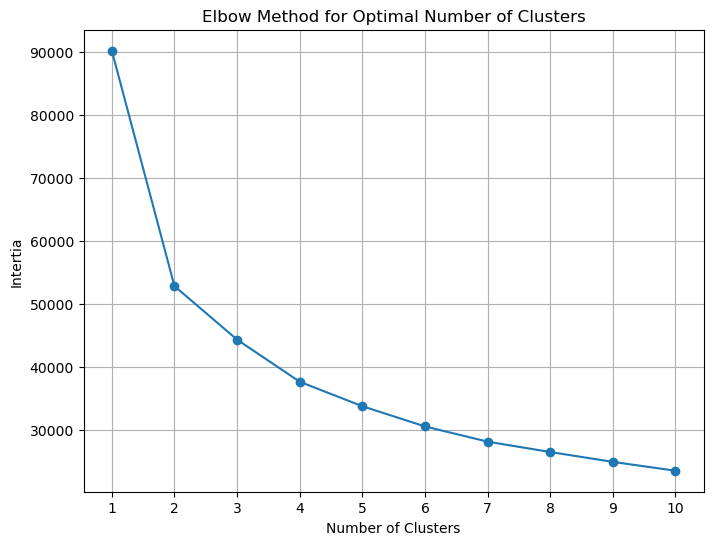

In [6]:
# Determine number of optimal clusters using Elbow method 
interia = []
cluster_range = range(1, 11)

for k in cluster_range:
    kmeans = KMeans(n_clusters = k, random_state = 42, n_init = 10)
    kmeans.fit(track_info_scaled)
    interia.append(kmeans.inertia_)

# Plot elbow curve 
plt.figure(figsize = (8, 6))
plt.plot(cluster_range, interia, marker = "o")
plt.title("Elbow Method for Optimal Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Intertia")
plt.xticks(cluster_range)
plt.grid(True)
plt.show()

In [7]:
# Number of optimal clusters = 4 
# Run KMeans with 4 clusters 
n_clusters = 4 

kmeans = KMeans(n_clusters = n_clusters, random_state = 42, n_init = 10)
track_info["Cluster"] = kmeans.fit_predict(track_info_scaled)

# Add cluster labels to dataset 
clustered_data = track_info.copy()

# Check distribution of clusters 
cluster_distribution = clustered_data["Cluster"].value_counts()
cluster_distribution 

/var/folders/w0/44d6yskx1qndyfb59znz0q5r0000gn/T/ipykernel_41811/4121332577.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_info["Cluster"] = kmeans.fit_predict(track_info_scaled)


Cluster
2    5029
0    4219
3    3168
1    2622
Name: count, dtype: int64

In [8]:
track_info_scaled_df["Cluster"] = track_info["Cluster"]
spotify_data["Cluster"] = track_info["Cluster"]

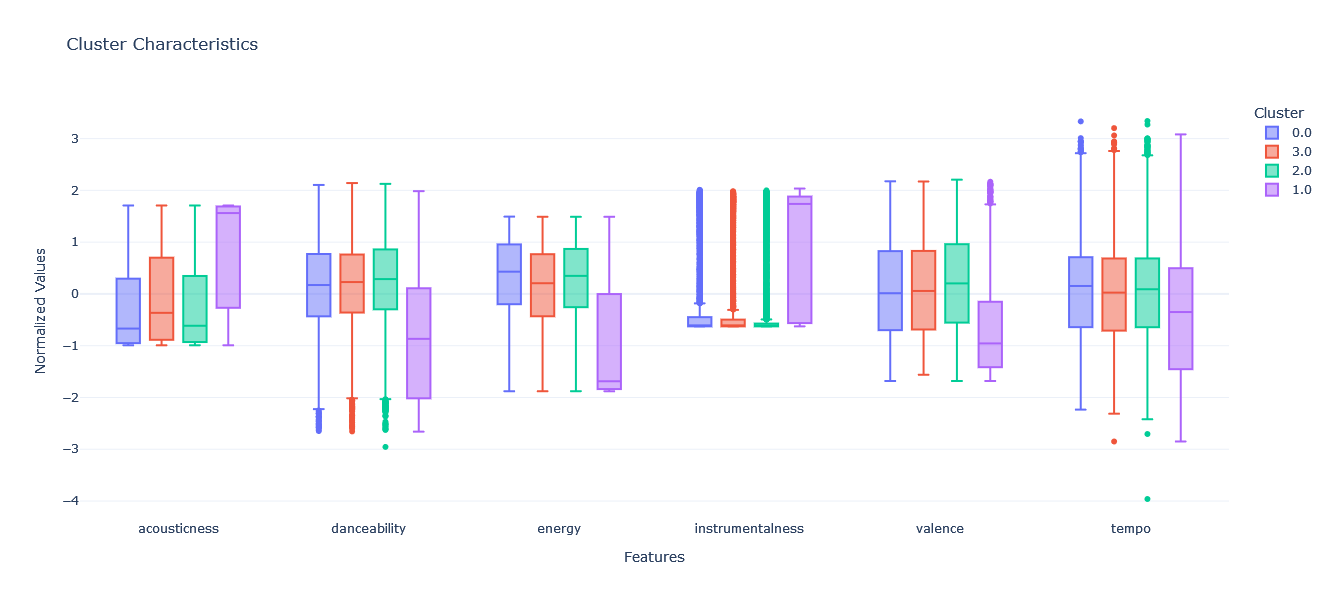

In [9]:
# Visualize clusters and their features 
melted_data = track_info_scaled_df.melt(id_vars = "Cluster",
                                     var_name = "Feature",
                                     value_name = "Value")

# Box plot for cluster characteristics 
fig = px.box(
    melted_data,
    x = "Feature", 
    y = "Value",
    color = "Cluster", 
    title = "Cluster Characteristics",
    labels = {"Value": "Normalized Values", "Feature": "Audio Feature"},
    height = 600
)

fig.update_layout(
    xaxis_title = "Features",
    yaxis_title = "Normalized Values",
    legend_title = "Cluster",
    boxmode = "group",
    template = "plotly_white"
)

fig.show()

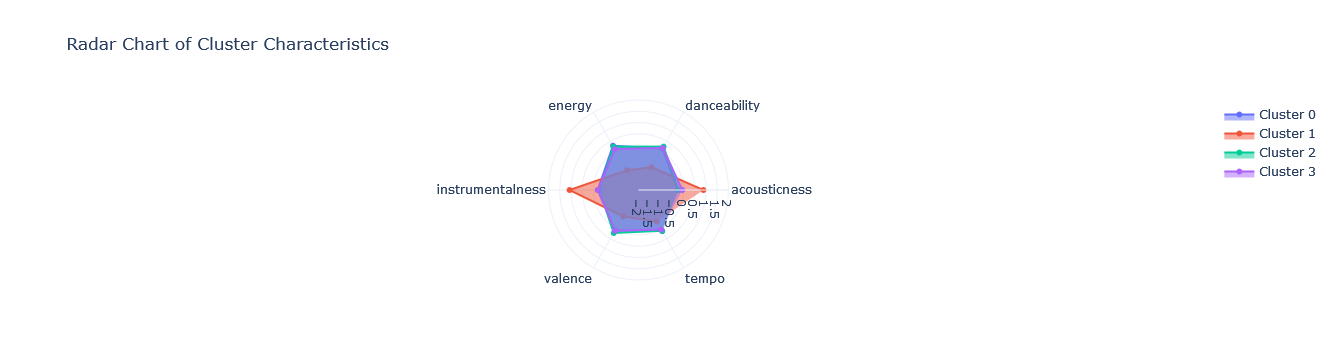

In [10]:
# Visualize average values of features for each cluster in radar chart 

# Get mean for each cluster
cluster_means = track_info_scaled_df.groupby("Cluster").mean()

# Prep data for radar plot 
cluster_means_reset = cluster_means.reset_index()
categories = cluster_means.columns 

# Create radar plot
fig = go.Figure()

# Add trace for each cluster
for i, row in cluster_means_reset.iterrows():
    fig.add_trace(go.Scatterpolar(
        r = row[categories].values,
        theta = categories,
        fill = "toself",
        name=f'Cluster {int(row["Cluster"])}'
    ))

# Update layout 
fig.update_layout(
    polar = dict(radialaxis = dict(visible = True, range = [-2, 2])),
    title = "Radar Chart of Cluster Characteristics",
    showlegend = True,
    template = "plotly_white"
)

fig.show()

In [11]:
# View where clusters overlap using PCA 
from sklearn.decomposition import PCA 

# Apply PCA to reduce dimensions to 2D
pca = PCA(n_components = 2)
track_pca = pca.fit_transform(track_info_scaled)

In [12]:
# Create dataframe for PCA results with clusters
pca_df = pd.DataFrame(track_pca, columns = ["PC1", "PC2"])
pca_df["KMeans_Cluster"] = track_info_scaled_df["Cluster"]

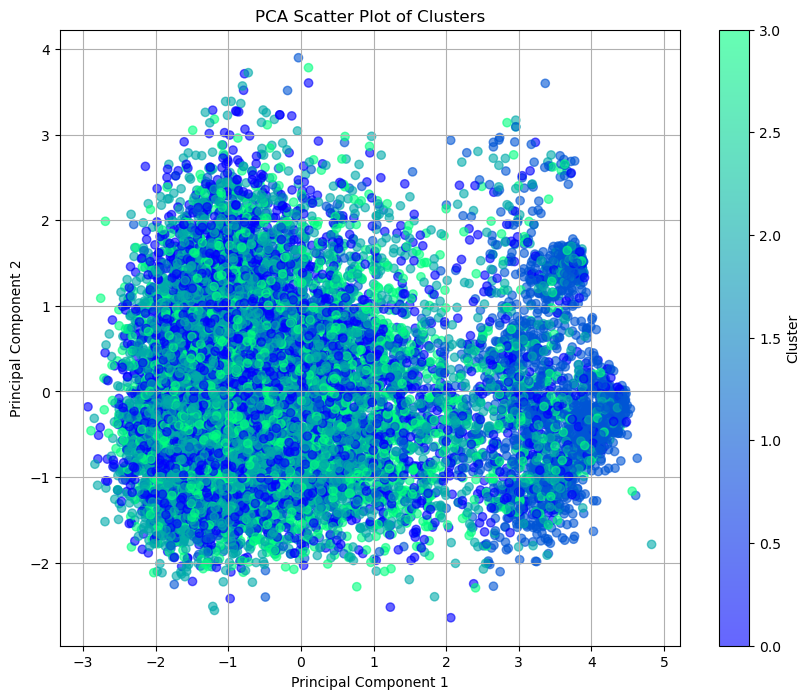

In [14]:
# Plot results
plt.figure(figsize = (10, 8))
scatter = plt.scatter(pca_df["PC1"], pca_df["PC2"], c = pca_df["KMeans_Cluster"], cmap = "winter", alpha = 0.6)

plt.colorbar(scatter, label = "Cluster")
plt.title("PCA Scatter Plot of Clusters")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()

In [15]:
# Trying to cluster differently using DBSCAN 
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps = 0.5, min_samples = 10)
dbscan_labels = dbscan.fit_predict(track_info_scaled)

pca_df["DBSCAN_Cluster"] = dbscan_labels

In [34]:
spotify_data["DBSCAN_Cluster"] = dbscan_labels

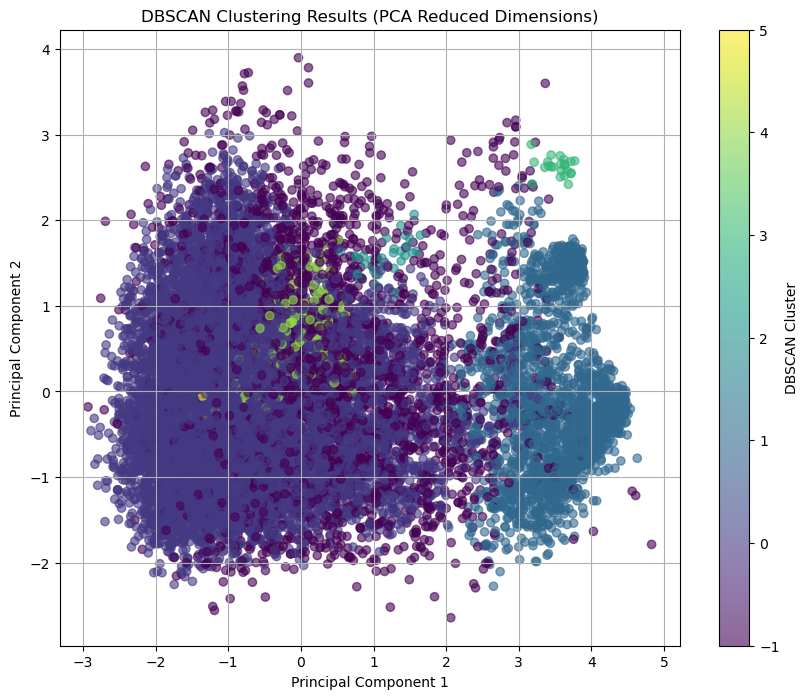

In [16]:
# Plot DBSCAN results
plt.figure(figsize = (10, 8))
scatter = plt.scatter(
    pca_df['PC1'], pca_df['PC2'], c = pca_df['DBSCAN_Cluster'], cmap = 'viridis', alpha = 0.6)

plt.colorbar(scatter, label = 'DBSCAN Cluster')
plt.title('DBSCAN Clustering Results (PCA Reduced Dimensions)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()


In [17]:
# Analyze the DBSCAN clustering results for noise
# Noise points are labeled as -1 by DBSCAN
# Count the number of noise points and points in clusters
cluster_counts = pd.Series(dbscan_labels).value_counts()
num_noise_points = cluster_counts.get(-1, 0)  # Noise points are labeled as -1
num_clusters = cluster_counts[cluster_counts.index != -1].count()  # Exclude noise

# Display noise and cluster analysis
noise_percentage = (num_noise_points / len(dbscan_labels)) * 100

results_summary = {
    "Total Points": len(dbscan_labels),
    "Number of Noise Points": num_noise_points,
    "Noise Percentage (%)": round(noise_percentage, 2),
    "Number of Clusters (Excluding Noise)": num_clusters
}

results_summary

{'Total Points': 15038,
 'Number of Noise Points': 3133,
 'Noise Percentage (%)': 20.83,
 'Number of Clusters (Excluding Noise)': 6}

1. **Noise**: Approximately 20.83% of the points are classified as noise. This indicates that a significant portion of the data does not belong to any dense region as per the current eps and min_samples parameters.
2. **Clusters**: DBSCAN identified 6 meaningful clusters in the data.

In [19]:
track_info_scaled_df

acousticness  danceability    energy  instrumentalness   valence  \
0         -0.980188     -0.521066  0.733478         -0.622885 -0.403925   
1         -0.690909     -0.552326 -1.049423         -0.625469 -0.979691   
2         -0.991664     -2.104865  1.283881         -0.618525 -0.052945   
3         -0.205705     -0.328301 -0.684739         -0.626457 -0.530121   
4          0.154809     -1.135830  1.054265         -0.626469 -0.920537   
...             ...           ...       ...               ...       ...   
15033     -0.541824      0.640733  0.719971         -0.626017  1.047320   
15034     -0.857885      0.020759  0.790882         -0.626469  0.625355   
15035      0.791809      0.088488 -0.097192         -0.611329 -0.565613   
15036     -0.990061      1.172139  0.736855         -0.626457  0.775212   
15037     -0.446952      1.458681  0.270869         -0.088798 -1.480923   

          tempo  Cluster  
0     -0.325863      0.0  
1     -1.025526      3.0  
2      2.161535      0.0  
3      0.714223      3.0  
4      0.268533      0.0  
...         ...      ...  
15033  1.747970      2.0  
15034  0.090822      0.0  
15035 -0.573498      2.0  
15036  0.486002      2.0  
15037  0.022724      2.0  

[15038 rows x 7 columns]

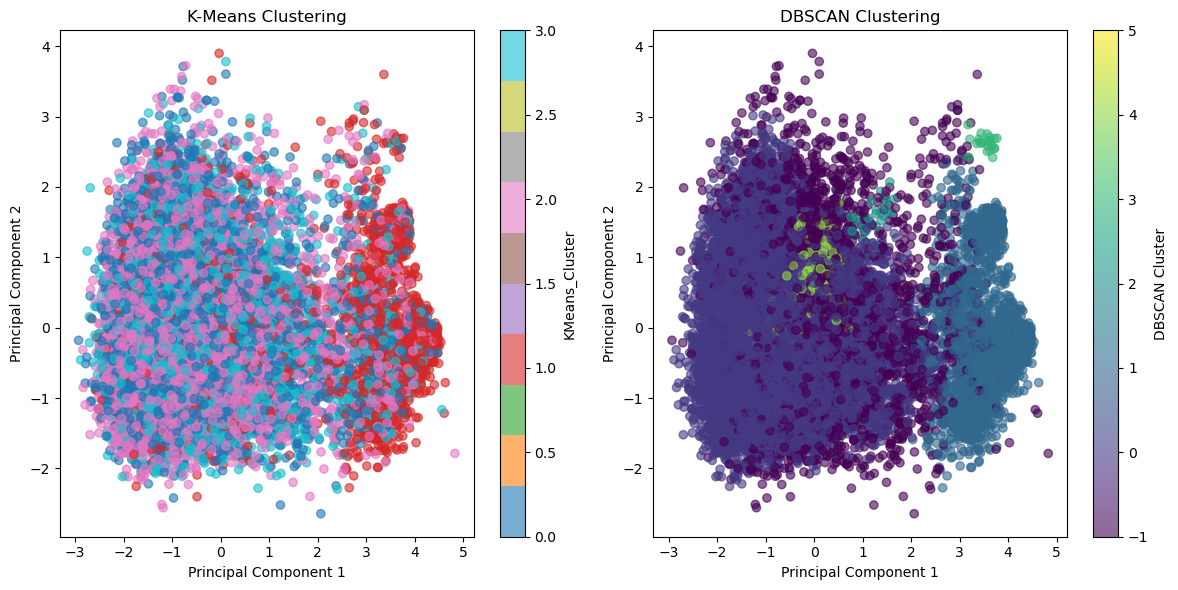

In [21]:
# Compare cluster counts
kmeans_counts = track_info_scaled_df['Cluster'].value_counts()
dbscan_counts = pd.Series(dbscan_labels).value_counts()

# Plot K-Means and DBSCAN clusters in PCA space
plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
plt.scatter(pca_df['PC1'], pca_df['PC2'], c = pca_df['KMeans_Cluster'], cmap = 'tab10', alpha = 0.6)
plt.colorbar(label =  "KMeans_Cluster")
plt.title("K-Means Clustering")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

plt.subplot(1, 2, 2)
plt.scatter(pca_df['PC1'], pca_df['PC2'], c = pca_df['DBSCAN_Cluster'], cmap = 'viridis', alpha = 0.6)
plt.colorbar(label = "DBSCAN Cluster")
plt.title("DBSCAN Clustering")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

plt.tight_layout()
plt.show()


In [22]:
kmeans_df = track_info_scaled_df.groupby("Cluster").mean()
dbscan_df = pca_df.groupby("DBSCAN_Cluster").mean()

In [23]:
kmeans_df

acousticness  danceability    energy  instrumentalness   valence  \
Cluster                                                                     
0.0         -0.247045      0.124781  0.273003         -0.191180  0.080181   
1.0          0.883494     -0.832058 -0.986118          1.064906 -0.643514   
2.0         -0.219572      0.227607  0.220969         -0.264075  0.205908   
3.0         -0.054094      0.161748  0.102251         -0.206951  0.098333   

            tempo  
Cluster            
0.0      0.110345  
1.0     -0.381478  
2.0      0.091079  
3.0      0.025924

In [24]:
dbscan_df

PC1       PC2  KMeans_Cluster
DBSCAN_Cluster                                    
-1              0.201381  0.198297        1.515326
 0             -0.881972 -0.079079        1.537862
 1              3.512711 -0.063837        1.164282
 2              1.137898  1.561970        1.764706
 3              3.529349  2.626911        1.347826
 4             -0.277374  0.500971        1.295918
 5             -1.483298 -0.209757        1.909091

1. Cluster Count

- K-Means: Produces a fixed number of clusters (n_clusters), regardless of the data's structure. For example, if you specified 4 clusters, K-Means will create exactly 4 clusters.
- DBSCAN: Dynamically determines the number of clusters based on the data's density. It may produce fewer or more clusters than K-Means and can classify some points as noise (label -1).

- Observation: If the data contains a lot of overlapping regions or sparse areas, DBSCAN may generate fewer clusters or significant noise, while K-Means will evenly divide the points into the specified clusters.

2. Cluster Sizes

- K-Means: Tends to create clusters of relatively similar size because it minimizes the sum of squared distances within each cluster.
- DBSCAN: Can create clusters of varying sizes because it groups points based on density.

- Observation: If the cluster sizes are uneven in DBSCAN, it could suggest some clusters are denser regions while others are sparser. K-Means may smooth out such variations, potentially misclassifying outliers into one of the predefined clusters.


3. Noise Handling

- K-Means: Does not handle noise explicitly; all points are assigned to a cluster.
- DBSCAN: Explicitly identifies noise points (labeled -1) that don’t belong to any cluster.

- Observation: If DBSCAN identifies a significant proportion of points as noise, it may indicate that these points are far from dense regions. K-Means, in contrast, assigns these points to the nearest cluster, which could distort the cluster's true characteristics.

4. Sensitivity to Parameters

- K-Means: Sensitive to the initial selection of centroids and the value of n_clusters. Poor initialization can lead to suboptimal clustering.
- DBSCAN: Sensitive to the eps (radius for neighborhood) and min_samples parameters. Improper values can result in too many clusters, excessive noise, or merging distinct clusters.

- Observation: Tuning parameters is crucial for DBSCAN to find meaningful clusters, while K-Means relies more on choosing the appropriate n_clusters.

5. Clustering in PCA Space

- When visualized in a 2D PCA scatter plot:
    - K-Means may appear to create clusters that are circular or elliptical in shape, reflecting its distance-based approach.
    - DBSCAN may create irregularly shaped clusters, which are more natural in some datasets.

- Observation: If the clusters are naturally irregularly shaped (e.g., elongated or crescent-shaped), DBSCAN may capture these patterns better than K-Means.

6. Application Suitability

- K-Means: Works well when clusters are well-separated, compact, and spherical in the feature space.
- DBSCAN: Works better for identifying arbitrary-shaped clusters and handling noise or outliers effectively.

- Observation: If the data has outliers or irregularly shaped clusters, DBSCAN may provide more meaningful results. K-Means might work better for well-structured, regularly spaced data.

Example Observations for Spotify Data

- Cluster Characteristics: K-Means clusters may show more balanced averages across features, while DBSCAN clusters might capture more distinct high-density regions.
- Noise: DBSCAN likely identified noise points in sparse areas of the feature space, which K-Means would have assigned to the nearest cluster.
- Number of Clusters: DBSCAN produced a dynamic number of clusters, possibly fewer or more than K-Means, depending on the density of the dataset.

Conclusion:

The choice between K-Means and DBSCAN depends on your dataset and objectives:

- Use K-Means for structured, well-separated data with a predefined number of clusters.
- Use DBSCAN for detecting noise, handling irregularly shaped clusters, or finding clusters dynamically.

In [25]:
# Example user to create a personalized playlist based on KMeans clustering
user_preferences = {
    "acousticness": 0.2, # low acoustic sound
    "danceability": 0.9, # high danceability
    "energy": 0.8, # high energy
    "instrumentalness": 0.1, # low instrumental sound
    "valence": 0.7, # positive mood
    "tempo": 120 # medium tempo
}

In [32]:
# Normalize user preferences
user_pref_scaled = scaler.transform([list(user_preferences.values())])

# Predict cluster for user 
user_cluster = kmeans.predict(user_pref_scaled)[0]

# Get songs from the predicted cluster
recommended_songs = spotify_data[spotify_data["Cluster"] == user_cluster]

# Display the first few songs
recommended_song_summary = recommended_songs[['names', 'artists', 'danceability', 'energy', 'valence', 'tempo']].reset_index(drop = True).head(10)

/Users/umreenimam/anaconda3/envs/base_clone/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names



In [33]:
recommended_song_summary

names                 artists  danceability  energy  \
0                   Cut You In  5HUFo8AH9ZILmlyKFfEMNP         0.632   0.742   
1                        Alive  1w5Kfo2jwwIPruYS2UWh56         0.284   0.875   
2                      Revolve  6aVjo0xHSiuW5hkasoYSR3         0.448   0.796   
3             Between The Eyes  43wwctvUaVOoEHEijQ8NpF         0.634   0.909   
4  Outshined - Remastered 2016  5xUf6j4upBrXZPg6AI4MRK         0.485   0.841   
5        Daughter - Remastered  1w5Kfo2jwwIPruYS2UWh56         0.615   0.702   
6                   Far Behind  3R6c2tWDBeYB1GncjLMn9n         0.552   0.645   
7           Pretend We're Dead  2zMQOJ4Cyl4BYbw6WqaO3h         0.569   0.789   
8           Fell On Black Days  5xUf6j4upBrXZPg6AI4MRK         0.574   0.739   
9         Would You Go With Me  7vCtweS8UVAXTyau2j0rDT         0.605   0.864   

   valence    tempo  
0    0.725  119.509  
1    0.595   75.009  
2    0.565   97.178  
3    0.816  103.398  
4    0.551   94.867  
5    0.734   96.987  
6    0.588   89.518  
7    0.911  115.152  
8    0.514  101.069  
9    0.736  122.919

In [35]:
# Create DBSCAN playlist recommendation
# Use the same user prefs 

# Predict DBSCAN cluster
user_dbscan_cluster = dbscan.fit_predict(user_pref_scaled)[0]

if user_dbscan_cluster != 1: 
    dbscan_playlist = spotify_data[dbscan_labels == user_dbscan_cluster][
        ["names", "artists", "danceability", "energy", "valence", "tempo"]
    ].head(10)
else:
    dbscan_playlist = pd.DataFrame(
        columns = ["names", "artists", "danceability", "energy", "valence", "tempo"],
        data = [["No recommendations", "N/A", "N/A", "N/A", "N/A", "N/A"]]
    )

In [43]:
recommended_song_summary

names                     ids  danceability  energy  \
0                   Cut You In  5HUFo8AH9ZILmlyKFfEMNP         0.632   0.742   
1                        Alive  1w5Kfo2jwwIPruYS2UWh56         0.284   0.875   
2                      Revolve  6aVjo0xHSiuW5hkasoYSR3         0.448   0.796   
3             Between The Eyes  43wwctvUaVOoEHEijQ8NpF         0.634   0.909   
4  Outshined - Remastered 2016  5xUf6j4upBrXZPg6AI4MRK         0.485   0.841   
5        Daughter - Remastered  1w5Kfo2jwwIPruYS2UWh56         0.615   0.702   
6                   Far Behind  3R6c2tWDBeYB1GncjLMn9n         0.552   0.645   
7           Pretend We're Dead  2zMQOJ4Cyl4BYbw6WqaO3h         0.569   0.789   
8           Fell On Black Days  5xUf6j4upBrXZPg6AI4MRK         0.574   0.739   
9         Would You Go With Me  7vCtweS8UVAXTyau2j0rDT         0.605   0.864   

   valence    tempo  
0    0.725  119.509  
1    0.595   75.009  
2    0.565   97.178  
3    0.816  103.398  
4    0.551   94.867  
5    0.734   96.987  
6    0.588   89.518  
7    0.911  115.152  
8    0.514  101.069  
9    0.736  122.919

In [44]:
dbscan_playlist

names                     ids  danceability  \
1                  River Of Deceit  0T7JQxpy1Li93vLNirbv0Z         0.461   
2             Shadow of the Season  3Ukr3Ufjg8ygRJv7Ww887f         0.163   
4                 Swallow My Pride  1XIIxzmo6BNRR4QkImSdsX         0.349   
5                Touch Me I'm Sick  7LuYiSXiWs86rwWJjEEgB9         0.354   
9                            Alive  1w5Kfo2jwwIPruYS2UWh56         0.284   
10                 Nearly Lost You  3Ukr3Ufjg8ygRJv7Ww887f         0.192   
12  Sex Type Thing - 2017 Remaster  2UazAtjfzqBF0Nho2awK4z         0.406   
13                   Jezebel Woman  6iQ35vbjuK5T4QkhihmNih         0.217   
14                     Burn a Hole  0sPa3yPonEuDbDhBzz7g4E         0.232   
15                         Revolve  6aVjo0xHSiuW5hkasoYSR3         0.448   

    energy  valence    tempo  
1    0.246    0.178   88.446  
2    0.937    0.413  184.482  
4    0.869    0.193  127.440  
5    0.941    0.569  131.442  
9    0.875    0.595   75.009  
10   0.908    0.481  201.254  
12   0.925    0.773  134.252  
13   0.736    0.246  130.404  
14   0.876    0.133  103.556  
15   0.796    0.565   97.178